In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from yahoo_fin import stock_info as si
from collections import deque
import yfinance as yf
from pathlib import Path

import os
import numpy as np
import pandas as pd
import random

In [30]:
def getTickerPriceData(tickers,period='7300d', interval='1d'):
    #Getting Ticker Price Data (Open,High,Close,etc)
    ticker_df = yf.download(tickers=tickers,period=period,interval=interval)
    return ticker_df

In [31]:
#getTickerPriceData('SPY')

In [32]:
def shuffle_in_unison(a, b):
    # shuffle two arrays in the same way
    state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(state)
    np.random.shuffle(b)

def load_data(ticker, n_steps=50, scale=True, shuffle=False, lookup_step=1, split_by_date=True,
                test_size=0.2, feature_columns=['Adj Close', 'Volume', 'Open', 'High', 'Low']):
    """
    Loads data from Yahoo Finance source, as well as scaling, shuffling, normalizing and splitting.
    Params:
        ticker (str/pd.DataFrame): the ticker you want to load, examples include AAPL, TESL, etc.
        n_steps (int): the historical sequence length (i.e window size) used to predict, default is 50
        scale (bool): whether to scale prices from 0 to 1, default is True
        shuffle (bool): whether to shuffle the dataset (both training & testing), default is True
        lookup_step (int): the future lookup step to predict, default is 1 (e.g next day)
        split_by_date (bool): whether we split the dataset into training/testing by date, setting it 
            to False will split datasets in a random way
        test_size (float): ratio for test data, default is 0.2 (20% testing data)
        feature_columns (list): the list of features to use to feed into the model, default is everything grabbed from yahoo_fin
    """
    # see if ticker is already a loaded stock from yahoo finance
    if isinstance(ticker, str):
        # load it from yfinance
        df = getTickerPriceData(ticker)
    elif isinstance(ticker, pd.DataFrame):
        # already loaded, use it directly
        df = ticker
    else:
        raise TypeError("ticker can be either a str or a `pd.DataFrame` instances")
    # this will contain all the elements we want to return from this function
    result = {}
    # we will also return the original dataframe itself
    result['df'] = df.copy()
    # make sure that the passed feature_columns exist in the dataframe
    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."
    # add date as a column
    if "date" not in df.columns:
        df["date"] = df.index
    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler
        # add the MinMaxScaler instances to the result returned
        result["column_scaler"] = column_scaler
    # add the target column (label) by shifting by `lookup_step`
    df['future'] = df['Adj Close'].shift(-lookup_step)
    # last `lookup_step` columns contains NaN in future column
    # get them before droping NaNs
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    # drop NaNs
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=n_steps)
    for entry, target in zip(df[feature_columns + ["date"]].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])
    # get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
    # for instance, if n_steps=50 and lookup_step=10, last_sequence should be of 60 (that is 50+10) length
    # this last_sequence will be used to predict future stock prices that are not available in the dataset
    last_sequence = list([s[:len(feature_columns)] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)
    # add to result
    result['last_sequence'] = last_sequence
    # construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)
    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    if split_by_date:
        # split the dataset into training & testing sets by date (not randomly splitting)
        train_samples = int((1 - test_size) * len(X))
        result["X_train"] = X[:train_samples]
        result["y_train"] = y[:train_samples]
        result["X_test"]  = X[train_samples:]
        result["y_test"]  = y[train_samples:]
        if shuffle:
            # shuffle the datasets for training (if shuffle parameter is set)
            shuffle_in_unison(result["X_train"], result["y_train"])
            shuffle_in_unison(result["X_test"], result["y_test"])
    else:    
        # split the dataset randomly
        result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, 
                                                                                test_size=test_size, shuffle=shuffle)
    # get the list of test set dates
    dates = result["X_test"][:, -1, -1]
    # retrieve test features from the original dataframe
    result["test_df"] = result["df"].loc[dates]
    # remove duplicated dates in the testing dataframe
    result["test_df"] = result["test_df"][~result["test_df"].index.duplicated(keep='first')]
    # remove dates from the training/testing sets & convert to float32
    result["X_train"] = result["X_train"][:, :, :len(feature_columns)].astype(np.float32)
    result["X_test"] = result["X_test"][:, :, :len(feature_columns)].astype(np.float32)
    return result

In [33]:
import os
import time
from tensorflow.keras.layers import LSTM

# Window size or the sequence length
N_STEPS = 50
# Lookup step, 1 is the next day
LOOKUP_STEP = 10
# whether to scale feature columns & output price as well
SCALE = True
scale_str = f"sc-{int(SCALE)}"
# whether to shuffle the dataset
SHUFFLE = False
shuffle_str = f"sh-{int(SHUFFLE)}"
# whether to split the training/testing set by date
SPLIT_BY_DATE = True
split_by_date_str = f"sbd-{int(SPLIT_BY_DATE)}"
# test ratio size, 0.2 is 20%
TEST_SIZE = 0.2
# features to use
FEATURE_COLUMNS = ["Adj Close", "Volume", "Open", "High", "Low"]
# date now
date_now = time.strftime("%Y-%m-%d")
### model parameters
N_LAYERS = 2
# LSTM cell
CELL = LSTM
# 256 LSTM neurons
UNITS = 256
# 40% dropout
DROPOUT = 0.4
# whether to use bidirectional RNNs
BIDIRECTIONAL = False
### training parameters
# mean absolute error loss
LOSS = "mae"
# huber loss
#LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 64
EPOCHS = 10
# AAPL stock market
ticker = "AAPL"
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")
# model name to save, making it as unique as possible based on parameters
model_name = f"{date_now}_{ticker}-{shuffle_str}-{scale_str}-{split_by_date_str}-\
{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"
if BIDIRECTIONAL:
    model_name += "-b"

In [34]:
# load the data
from tensorflow.keras.models import model_from_json

data = load_data(ticker, N_STEPS, scale=SCALE, split_by_date=SPLIT_BY_DATE, 
                shuffle=SHUFFLE, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, 
                feature_columns=FEATURE_COLUMNS)

# load json and create model
file_path = Path("aaplmodel_10day.json")
with open(file_path, "r") as json_file:
    model_json = json_file.read()
aaplmodel_10day = model_from_json(model_json)

# load weights into new model
file_path = "aaplmodel_10day.h5"
aaplmodel_10day.load_weights(file_path)


[*********************100%***********************]  1 of 1 completed


In [35]:
data

{'df':                   Open        High         Low       Close   Adj Close  \
 Date                                                                     
 1992-04-03    0.524554    0.529018    0.522321    0.526786    0.434046   
 1992-04-06    0.526786    0.544643    0.526786    0.542411    0.446921   
 1992-04-07    0.544643    0.546875    0.511161    0.511161    0.421172   
 1992-04-08    0.508929    0.508929    0.488839    0.498884    0.411057   
 1992-04-09    0.500000    0.520089    0.493304    0.511161    0.421172   
 ...                ...         ...         ...         ...         ...   
 2021-03-23  123.330002  124.239998  122.139999  122.540001  122.540001   
 2021-03-24  122.820000  122.900002  120.070000  120.089996  120.089996   
 2021-03-25  119.540001  121.660004  119.000000  120.589996  120.589996   
 2021-03-26  120.349998  121.480003  118.919998  121.209999  121.209999   
 2021-03-29  121.650002  122.580002  120.729897  121.389999  121.389999   
 
                V

In [36]:
import matplotlib.pyplot as plt

def plot_graph(test_df):
    """
    This function plots true close price along with predicted close price
    with blue and red colors respectively
    """
    plt.plot(test_df[f'true_adjclose_{LOOKUP_STEP}'], c='b')
    plt.plot(test_df[f'adjclose_{LOOKUP_STEP}'], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()

In [37]:
def get_final_df(model, data):
    """
    This function takes the `model` and `data` dict to 
    construct a final dataframe that includes the features along 
    with true and predicted prices of the testing dataset
    """
    # if predicted future price is higher than the current, 
    # then calculate the true future price minus the current price, to get the buy profit
    buy_profit  = lambda current, true_future, pred_future: true_future - current if pred_future > current else 0
    # if the predicted future price is lower than the current price,
    # then subtract the true future price from the current price
    sell_profit = lambda current, true_future, pred_future: current - true_future if pred_future < current else 0
    X_test = data["X_test"]
    y_test = data["y_test"]
    # perform prediction and get prices
    y_pred = model.predict(X_test)
    if SCALE:
        y_test = np.squeeze(data["column_scaler"]["Adj Close"].inverse_transform(np.expand_dims(y_test, axis=0)))
        y_pred = np.squeeze(data["column_scaler"]["Adj Close"].inverse_transform(y_pred))
    test_df = data["test_df"]
    # add predicted future prices to the dataframe
    test_df[f"adjclose_{LOOKUP_STEP}"] = y_pred
    # add true future prices to the dataframe
    test_df[f"true_adjclose_{LOOKUP_STEP}"] = y_test
    # sort the dataframe by date
    test_df.sort_index(inplace=True)
    final_df = test_df
    # add the buy profit column
    final_df["buy_profit"] = list(map(buy_profit, 
                                    final_df["Adj Close"], 
                                    final_df[f"adjclose_{LOOKUP_STEP}"], 
                                    final_df[f"true_adjclose_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    # add the sell profit column
    final_df["sell_profit"] = list(map(sell_profit, 
                                    final_df["Adj Close"], 
                                    final_df[f"adjclose_{LOOKUP_STEP}"], 
                                    final_df[f"true_adjclose_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    return final_df

In [38]:
def predict(model, data):
    # retrieve the last sequence from data
    last_sequence = data["last_sequence"][-N_STEPS:]
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    # get the price (by inverting the scaling)
    if SCALE:
        predicted_price = data["column_scaler"]["Adj Close"].inverse_transform(prediction)[0][0]
    else:
        predicted_price = prediction[0][0]
    return predicted_price

In [43]:
# get the final dataframe for the testing set
final_df = get_final_df(aaplmodel_10day, data)
final_df

,Open,High,Low,Close,Adj Close,Volume,adjclose_10,true_adjclose_10,buy_profit,sell_profit
Date,,,,,,,,,,
2015-06-12,32.047501,32.082500,31.777500,31.792500,29.153574,147544800,29.942493,29.057289,0.000000,-0.788919
2015-06-15,31.525000,31.809999,31.427500,31.730000,29.096258,175955600,29.816599,28.548355,0.000000,-0.720341
2015-06-16,31.757500,31.962500,31.592501,31.900000,29.252151,125976400,29.941366,28.754684,0.000000,-0.689215
2015-06-17,31.930000,31.969999,31.684999,31.825001,29.183380,131672400,29.925499,29.022902,0.000000,-0.742119
2015-06-18,31.807501,32.077499,31.805000,31.969999,29.316339,141628800,30.064116,28.986221,0.000000,-0.747776
...,...,...,...,...,...,...,...,...,...,...
2021-03-09,119.029999,122.059998,118.790001,121.089996,121.089996,129159600,26.488811,122.540001,-94.601185,0.000000
2021-03-10,121.690002,122.169998,119.449997,119.980003,119.980003,111760400,26.413969,120.089996,-93.566034,0.000000
2021-03-11,122.540001,123.209999,121.260002,121.959999,121.959999,102753600,26.088951,120.589996,0.000000,95.871048


In [40]:
# predict the future price
future_price = predict(aaplmodel_10day, data)

In [24]:
# we calculate the accuracy by counting the number of positive profits
accuracy_score = (len(final_df[final_df['sell_profit'] > 0]) + len(final_df[final_df['buy_profit'] > 0])) / len(final_df)
# calculating total buy & sell profit
total_buy_profit  = final_df["buy_profit"].sum()
total_sell_profit = final_df["sell_profit"].sum()
# total profit by adding sell & buy together
total_profit = total_buy_profit + total_sell_profit
# dividing total profit by number of testing samples (number of trades)
profit_per_trade = total_profit / len(final_df)

In [26]:
final_df

,Open,High,Low,Close,Adj Close,Volume,adjclose_10,true_adjclose_10,buy_profit,sell_profit
Date,,,,,,,,,,
2015-06-12,32.047501,32.082500,31.777500,31.792500,29.153574,147544800,29.942493,29.057289,0.000000,-0.788919
2015-06-15,31.525000,31.809999,31.427500,31.730000,29.096258,175955600,29.816599,28.548355,0.000000,-0.720341
2015-06-16,31.757500,31.962500,31.592501,31.900000,29.252151,125976400,29.941366,28.754684,0.000000,-0.689215
2015-06-17,31.930000,31.969999,31.684999,31.825001,29.183380,131672400,29.925499,29.022902,0.000000,-0.742119
2015-06-18,31.807501,32.077499,31.805000,31.969999,29.316339,141628800,30.064116,28.986221,0.000000,-0.747776
...,...,...,...,...,...,...,...,...,...,...
2021-03-09,119.029999,122.059998,118.790001,121.089996,121.089996,129159600,26.488811,122.540001,-94.601185,0.000000
2021-03-10,121.690002,122.169998,119.449997,119.980003,119.980003,111760400,26.413969,120.089996,-93.566034,0.000000
2021-03-11,122.540001,123.209999,121.260002,121.959999,121.959999,102753600,26.088951,120.589996,0.000000,95.871048


This model predicts the Future price after 10 days will be 26.19$


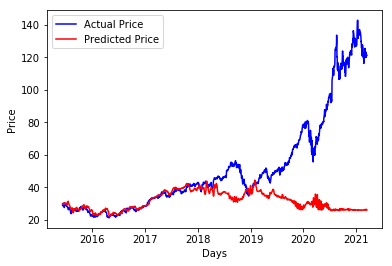

In [27]:
# printing metrics
print(f"This model predicts the Future price after {LOOKUP_STEP} days will be {future_price:.2f}$")
# plot true/pred prices graph
plot_graph(final_df)